In [0]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
    
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights=None
)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
    
pre_trained_model.summary()

--2019-06-12 04:02:43--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c15::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   132MB/s    in 0.6s    

2019-06-12 04:02:43 (132 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (

In [3]:
last_layer = pre_trained_model.get_layer('mixed7')
print("Last layer output shape:", last_layer.output_shape)
last_output = last_layer.output

('Last layer output shape:', (None, 7, 7, 768))


In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > 0.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

In [5]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_v1[0][0]

In [6]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
  
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '//tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()

--2019-06-12 04:07:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   117MB/s    in 1.2s    

2019-06-12 04:07:56 (117 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2019-06-12 04:07:58--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 2607:f8b0:400c:c10::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/z

In [0]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

In [11]:
train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [12]:
# Define our example directories and files
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

# Expected Output:
# Found 1027 images belonging to 2 classes.
# Found 256 images belonging to 2 classes.

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [13]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
13/13 [==============================] - 2s 164ms/step - loss: 0.0048 - acc: 0.9961
 - 14s - loss: 0.2895 - acc: 0.8773 - val_loss: 0.0048 - val_acc: 0.9961
Epoch 2/100
13/13 [==============================] - 1s 112ms/step - loss: 0.0507 - acc: 0.9766
 - 12s - loss: 0.0757 - acc: 0.9727 - val_loss: 0.0507 - val_acc: 0.9766
Epoch 3/100
13/13 [==============================] - 1s 112ms/step - loss: 0.0254 - acc: 0.9883
 - 12s - loss: 0.0738 - acc: 0.9718 - val_loss: 0.0254 - val_acc: 0.9883
Epoch 4/100
13/13 [==============================] - 1s 113ms/step - loss: 0.0077 - acc: 0.9961
 - 12s - loss: 0.0603 - acc: 0.9815 - val_loss: 0.0077 - val_acc: 0.9961
Epoch 5/100
13/13 [==============================] - 1s 111ms/step - loss: 0.0519 - acc: 0.9883
 - 12s - loss: 0.0520 - acc: 0.9786 - val_loss: 0.0519 - val_acc: 0.9883
Epoch 6/100
13/13 [==============================] - 1s 112ms/step - loss: 0.0115 - acc: 0.9883
 - 12s - lo

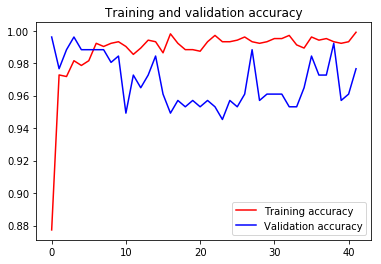

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()